<a href="https://colab.research.google.com/github/dubalker11/gravitationalwave/blob/main/BenWalker_Week7GWCoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp310-cp310-linux_x86_64.whl size=99256 sha256=db2dda527d226765f8432079e52077c96b763e56d33929e122364c19ab2646c2
  Stored in directory: /root/.cache/pip/wheels/6d/48/d1/3466977be4e41ba57f92ad0d5619f083df43cf319a151c4e06
Successfully built ligo-segments


In [2]:
# GPS time of gravitational wave GW200224_222234
t0 = 1266618172.4

from gwpy.timeseries import TimeSeries #import data
hdata = TimeSeries.fetch_open_data('H1', t0 - 16, t0 + 16) #create a 32 window around t0

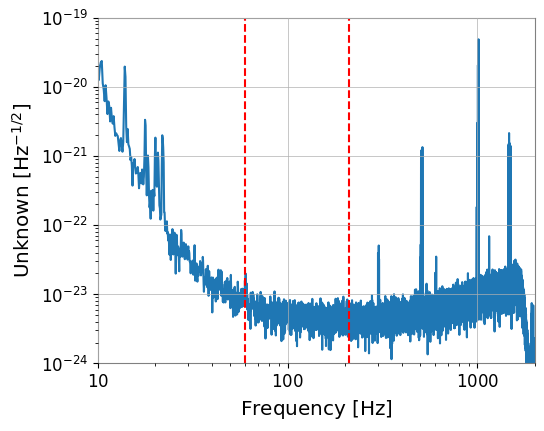

In [3]:
import matplotlib.pyplot as plt

#plot frequencies
fig2 = hdata.asd(fftlength = 8).plot()
plt.xlim(10,2000)
ymin = 1e-24
ymax = 1e-19
plt.ylim(ymin, ymax)
plt.vlines(60, ymin, ymax, linestyle = "dashed", color = "red") #unwanted frequency
plt.vlines(210, ymin, ymax, linestyle = "dashed", color = "red") #unwanted frequency

In [25]:
from gwpy.signal import filter_design
bp = filter_design.bandpass(50, 250, hdata.sample_rate) #set frequency window

notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 210)] #filter to remove these frequencies

zpk = filter_design.concatenate_zpks(bp, *notches)

hfilt = hdata.filter(zpk, filtfilt = True)

In [26]:
hdata = hdata.crop(*hdata.span.contract(1)) #crop out unwanted frequencies
hfilt = hfilt.crop(*hfilt.span.contract(1)) #data after filtering

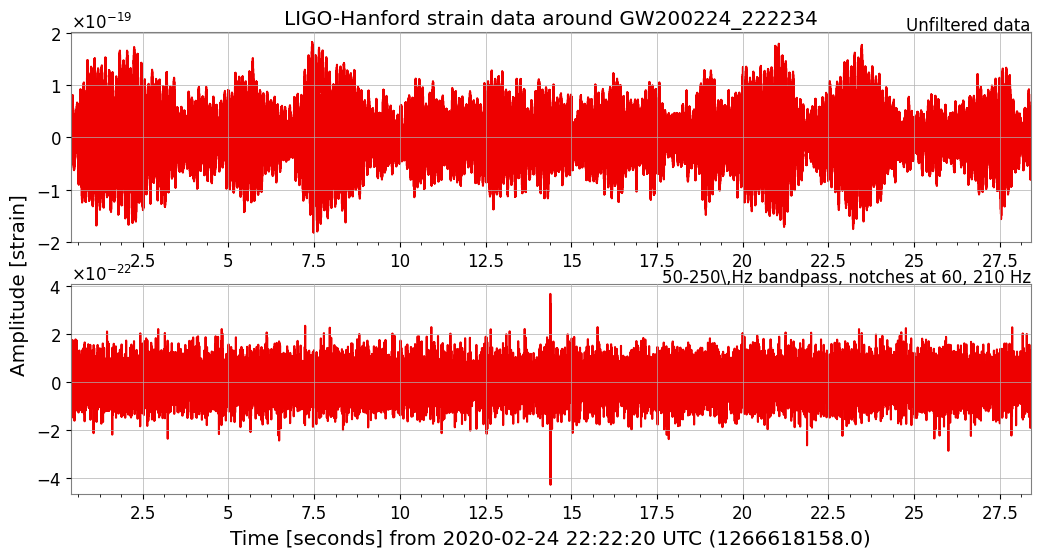

In [27]:
from gwpy.plot import Plot
plot = Plot(hdata, hfilt, figsize = [12, 6], separate = True, sharex = True,
            color = 'gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW200224_222234')
ax1.text(1.0, 1.01, 'Unfiltered data', transform = ax1.transAxes, ha = 'right')
ax1.set_ylabel('Amplitude [strain]', y = -0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 210 Hz',
         transform = ax2.transAxes, ha = 'right')
plot.show()

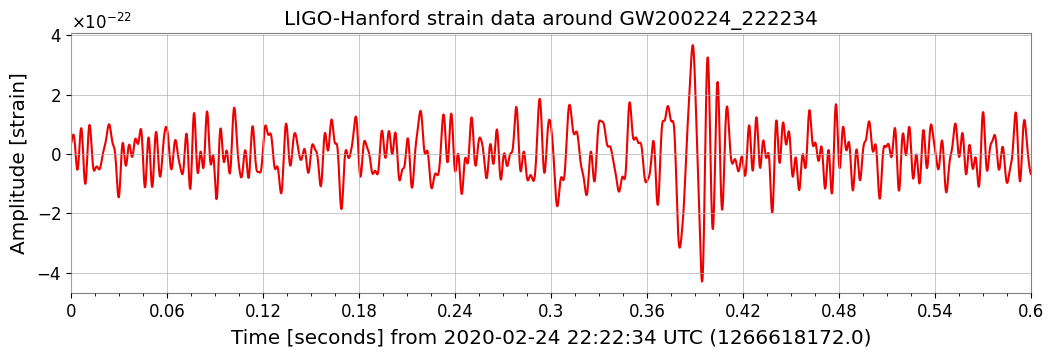

In [28]:
import matplotlib.pyplot as plt

plot = hfilt.plot(color = 'gwpy:ligo-hanford') #plot the filtered data
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW200224_222234')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(t0 - .4, t0 + .2)
ax.set_xscale('seconds', epoch = t0 - .4)
plot.show() #zoomed in to see gravitational wave

x_val = plt.gca().lines[0].get_xdata()
y_val = plt.gca().lines[0].get_ydata()

In [9]:
ldata = TimeSeries.fetch_open_data('L1', t0 - 15.4, t0 + 16.6) #Livingston
lfilt = ldata.filter(zpk, filtfilt=True)

In [10]:
lfilt.shift('6.9ms') #LIGO observes the gravitational wave 6.9ms after
lfilt *= -1

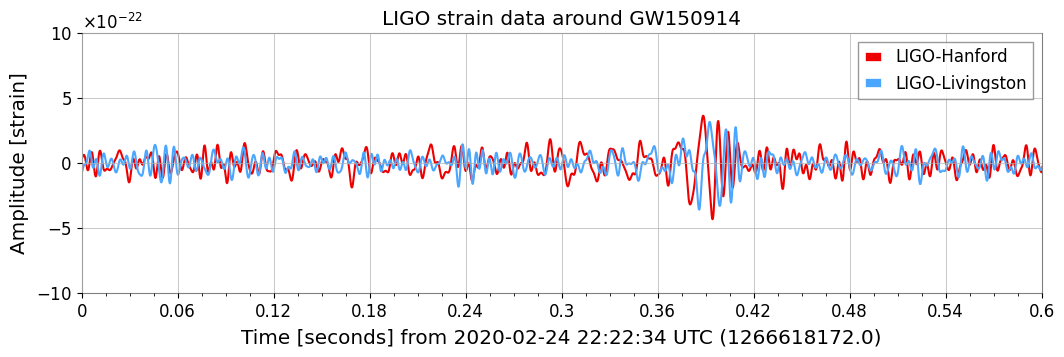

In [12]:
plot = Plot(figsize = [12, 4])
ax = plot.gca() #show data from both stations
ax.plot(hfilt, label = 'LIGO-Hanford', color = 'gwpy:ligo-hanford')
ax.plot(lfilt, label = 'LIGO-Livingston', color = 'gwpy:ligo-livingston')
ax.set_title('LIGO strain data around GW200224_222234')
ax.set_xlim(t0 - .4, t0 + .2)
ax.set_xscale('seconds', epoch = t0 - .4)
ax.set_ylabel('Amplitude [strain]')
ax.set_ylim(-1e-21, 1e-21)
ax.legend()
plot.show()

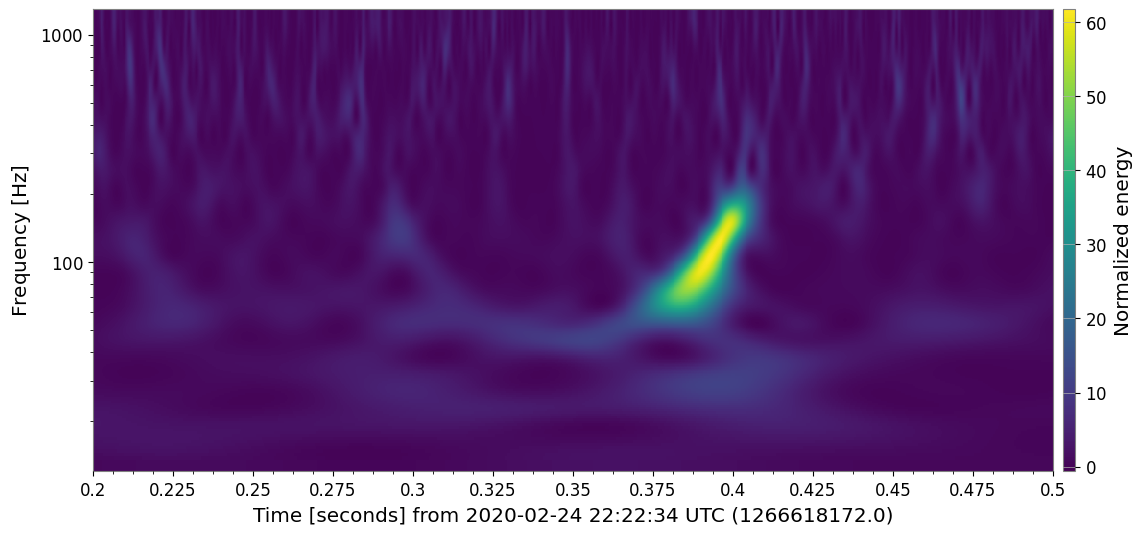

In [13]:
#show the intensity and frequency of the gravitational wave
dt = 0.2  #width of q-transform plot in seconds
hq = hfilt.q_transform(outseg = (t0 - dt, t0 + 0.1))
fig4 = hq.plot()
ax = fig4.gca()
fig4.colorbar(label = "Normalized energy")
ax.grid(False)
ax.set_yscale('log') #in-line with the graph above

In [14]:
from scipy.io.wavfile import write
import numpy as np

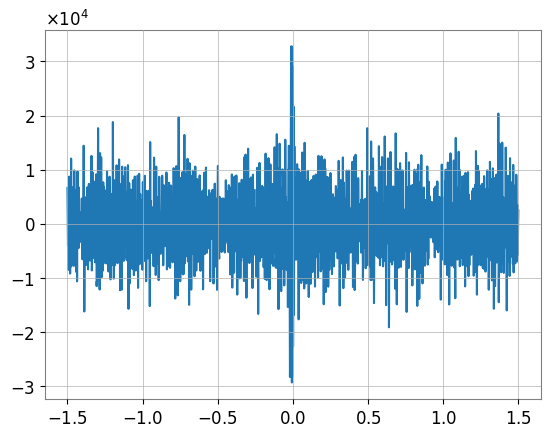

In [15]:
#now turn data into sound file
amplitude = np.iinfo(np.int16).max

ind = np.where((x_val < (t0 + 1.5)) & (x_val > (t0 - 1.5))) #select array at t0 with window of +-1.5
y = y_val[ind]
# y = y**3
y = y / np.max(y) #max amplitude
plt.plot(x_val[ind] - t0, (np.array(y) * amplitude).astype(np.int16))

In [16]:
fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0)))) #sampling rate
print("fs = ", fs)
write("example.wav", fs, (np.array(y) * amplitude).astype(np.int16))

fs =  4096


In [17]:
from google.colab import files
files.download("example.wav")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.5
fs =  4096


<ipython-input-33-2eccc8a0adf3>:40: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(x - t0, (np.array(y_old) * amplitude).astype(np.int16), label = "before frequency multiplication")
<ipython-input-33-2eccc8a0adf3>:47: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(x - t0, (np.array(y) * amplitude).astype(np.int16), label = "after frequency multiplication")
<ipython-input-33-2eccc8a0adf3>:55: ComplexWarning: Casting complex values to real discards the imaginary part
  write("example.wav", fs, (np.array(y[0:int(num/up_sample)]) * amplitude).astype(np.int16))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

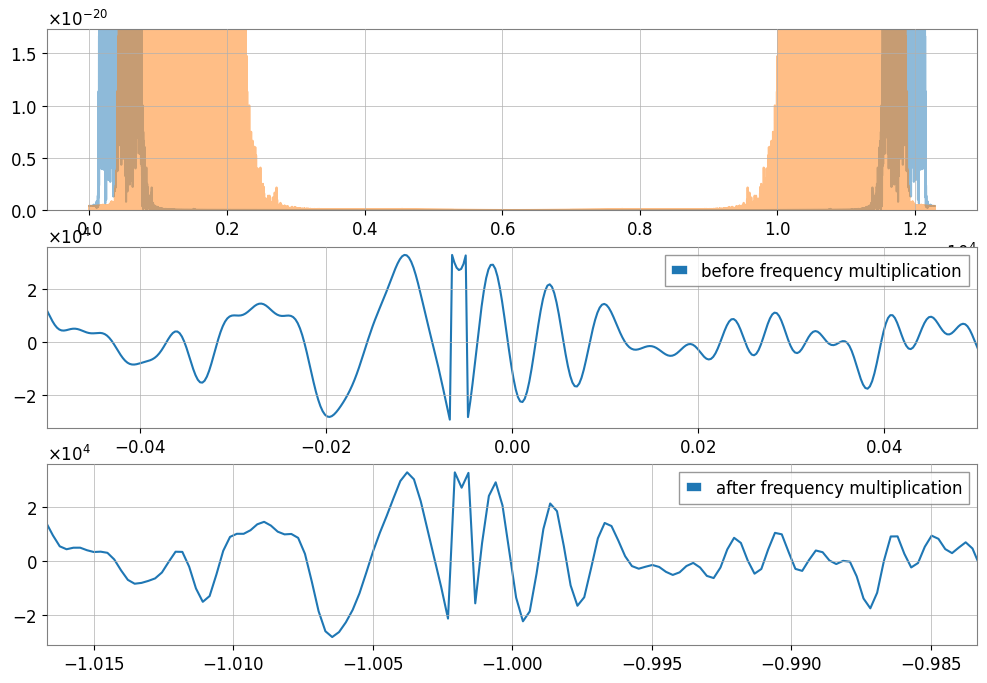

In [33]:
t_clip = 1.5 #width of the signal
amplitude = np.iinfo(np.int16).max

ind = np.where((x_val < (t0 + t_clip)) & (x_val > (t0 - t_clip)))
x = x_val[ind] #time
y = y_val[ind] #amplitude

up_sample = 3

y_fft = np.fft.fft(y) #fourier transformation of the data
y_fft_new = np.zeros(np.shape(y_fft), dtype = np.cdouble)
y_fft_old = y_fft

num = len(y_fft)
for i in np.arange(int(num / up_sample)):
    y_fft_new[int(i * up_sample)] = y_fft[int(i)]

y_old = np.fft.ifft(y_fft_old)

for i in np.arange(num):
  if i > (num / 2):
    y_fft_new[i] = np.conjugate(y_fft_new[int(num) - i])

y = np.fft.ifft(y_fft_new)

plt.figure(figsize = (12, 8))
plt.subplot(311)
plt.plot(np.abs(y_fft_old), alpha = 0.5) #before the fourier transformation
plt.plot(np.abs(y_fft_new), alpha = 0.5) #after the fourier transformation
ylim = np.percentile(np.abs(y_fft), 95)
plt.ylim(0, ylim)

plt.subplot(312)
#make the signal more distinct from the noise
y_old = y_old / np.max(y_old)
plt.plot(x - t0, (np.array(y_old) * amplitude).astype(np.int16), label = "before frequency multiplication")
plt.xlim(-0.05, 0.05)
plt.legend()

plt.subplot(313)
#make the signal more distinct from the noise
y = y / np.max(y)
plt.plot(x - t0, (np.array(y) * amplitude).astype(np.int16), label = "after frequency multiplication")
plt.xlim(-t_clip + t_clip / up_sample - 0.05 / up_sample, -t_clip + t_clip / up_sample + 0.05 / up_sample)
plt.legend()
print(t_clip / up_sample)

fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0))))
#make the signal higher pitch
print("fs = ", fs)
write("example.wav", fs, (np.array(y[0:int(num/up_sample)]) * amplitude).astype(np.int16))

from google.colab import files
files.download("example.wav")

In [19]:
#original, old, and new
print(y_fft[0:4], y_fft[-3:])
print(y_fft_new[0:10], y_fft_new[-3:])
print(y_fft_old[0:4], y_fft_old[-3:])

[-4.28009661e-22+0.00000000e+00j -4.28017381e-22+2.96565180e-25j
 -4.28040545e-22+5.93027354e-25j -4.28079160e-22+8.89283640e-25j] [-4.28079160e-22-8.89283640e-25j -4.28040545e-22-5.93027354e-25j
 -4.28017381e-22-2.96565180e-25j]
[-4.28009661e-22+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j -4.28017381e-22+2.96565180e-25j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -4.28040545e-22+5.93027354e-25j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j -4.28079160e-22+8.89283640e-25j] [-4.28017381e-22-2.9656518e-25j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j]
[-4.28009661e-22+0.00000000e+00j -4.28017381e-22+2.96565180e-25j
 -4.28040545e-22+5.93027354e-25j -4.28079160e-22+8.89283640e-25j] [-4.28079160e-22-8.89283640e-25j -4.28040545e-22-5.93027354e-25j
 -4.28017381e-22-2.96565180e-25j]


In [20]:
#edit sound file
!pip install pydub
from pydub import AudioSegment

In [21]:
#slow the sound
sound = AudioSegment.from_file("example.wav")
print(sound.frame_rate)
# sound.frame_rate = 1024
print(sound.frame_rate)
sound = sound.set_frame_rate(4096 * 4)
sound.frame_rate = 4096 * 2
sound.export("example_slow.wav")
files.download("example_slow.wav")

4096
4096


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.0, 0.1)

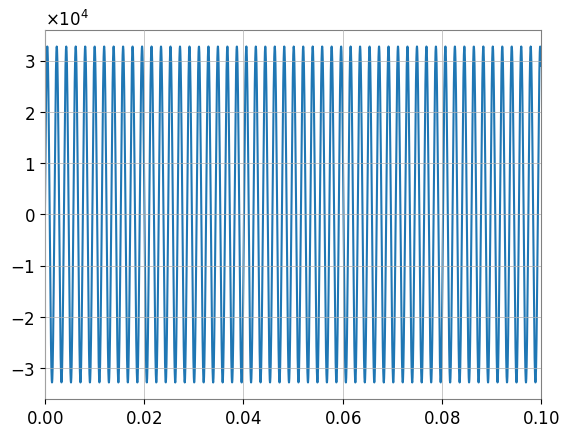

In [22]:
samplerate = 44100; fs = 261.63 * 2.0 #frequency
t = np.linspace(0., 1., samplerate) #how many in one second
amplitude = np.iinfo(np.int16).max #how loud
data = amplitude * np.sin(2. * np.pi * fs * t) #plot wave
plt.plot(t, data) #plot wave across time
plt.xlim(0, 0.1)

In [24]:
write("C.wav", samplerate, data.astype(np.int16))
files.download("C.wav")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>